Machine Learning Project

Yusuf Siddiqui 202006963

Abdullah Khan 202107912

Mohammad Hassan 201807929

In [2]:
# Import dependencies
import pandas as pd
import numpy as np
import sys
from sklearn.preprocessing import StandardScaler, LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, classification_report
from IPython.display import display  # Import display function for better DataFrame visualization
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import GridSearchCV


Opening dataset + Handling Missing Values

In [3]:
print(sys.version)
print('pandas version', pd.__version__)

# Load the dataset
df = pd.read_csv("C:/Users/yusuf/Desktop/Final ML/adult.csv")
print(df.shape)
df.rename(columns={'workclass': 'work.class'}, inplace=True)  
# Calculate the number of entries in the DataFrame
number_of_entries = df.shape[0]
print(f"The dataset contains {number_of_entries} entries.")
# Print the first few rows of the DataFrame
display(df.head())
# Remove rows where 'workclass' column has '?' as it is a critical feature and there is nothing we can do but drop it.
df = df[df['work.class'] != '?']
print("Shape after removing '?' entries:", df.shape)
number_of_us_entries = df[df['native.country'] == 'United-States'].shape[0]
print(f"The dataset contains {number_of_us_entries} entries for the United States.")
display(df.head())  # Display the first few rows after removing entries with '?'
# Replace '?' with 'United-States' in the 'native.country' column in df since the majority of the responses were from 'United-States'
df['native.country'].replace('?', 'United-States', inplace=True)
print("Updated df shape after replacing '?':", df.shape)
display(df.head())  # Display the first few rows after replacing




3.12.2 | packaged by conda-forge | (main, Feb 16 2024, 20:42:31) [MSC v.1937 64 bit (AMD64)]
pandas version 2.1.4
(32561, 15)
The dataset contains 32561 entries.


,age,work.class,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,?,77053,HS-grad,9,Widowed,?,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
2,66,?,186061,Some-college,10,Widowed,?,Unmarried,Black,Female,0,4356,40,United-States,<=50K
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K


Shape after removing '?' entries: (30725, 15)
The dataset contains 27511 entries for the United States.


,age,work.class,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K
5,34,Private,216864,HS-grad,9,Divorced,Other-service,Unmarried,White,Female,0,3770,45,United-States,<=50K
6,38,Private,150601,10th,6,Separated,Adm-clerical,Unmarried,White,Male,0,3770,40,United-States,<=50K


Updated df shape after replacing '?': (30725, 15)


,age,work.class,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K
5,34,Private,216864,HS-grad,9,Divorced,Other-service,Unmarried,White,Female,0,3770,45,United-States,<=50K
6,38,Private,150601,10th,6,Separated,Adm-clerical,Unmarried,White,Male,0,3770,40,United-States,<=50K


Correlation Matrix + Detecting Outliers

In [4]:
# Sort the DataFrame 'df' by the 'age' column in ascending order
sorted_df = df.sort_values(by='age')

# Display the first few rows of the sorted DataFrame to verify the sorting
display(sorted_df.head())
numerical_columns = ['fnlwgt', 'capital.gain', 'capital.loss', 'hours.per.week']

# Calculate the correlation matrix for numerical attributes
correlation_matrix = df[numerical_columns].corr()

# Display the correlation matrix
print(correlation_matrix)


def detect_and_count_outliers(df, features):
    outlier_indices = []
    outlier_counts = {}

    for col in features:
        # Calculate the IQR
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1

        # Define bounds for outliers
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Find indices of outliers
        outlier_list_col = df[(df[col] < lower_bound) | (df[col] > upper_bound)].index
        
        # Append outlier indices for the column to the list of outlier indices
        outlier_indices.extend(outlier_list_col)

        # Count outliers in the column and store in dictionary
        outliers_count = df[(df[col] < lower_bound) | (df[col] > upper_bound)].shape[0]
        outlier_counts[col] = outliers_count

    # Select observations containing more than one outlier
    outlier_indices = pd.Series(outlier_indices).value_counts()
    multiple_outliers = outlier_indices[outlier_indices > 1].index

    return multiple_outliers, outlier_counts

# Specify the columns to check for outliers
columns_to_check = ['fnlwgt', 'capital.gain', 'capital.loss', 'hours.per.week']

# Detect outliers and count them in the DataFrame
multiple_outliers, outlier_counts = detect_and_count_outliers(df, columns_to_check)

# Display the rows with multiple outliers
print("Displaying rows with multiple outliers:")
display(df.loc[multiple_outliers])

# Display the number of outliers per feature
print("Number of outliers per selected feature:")
for feature, count in outlier_counts.items():
    print(f"{feature}: {count}")
# Find the highest value for the 'age' column
highest_age = df['age'].max()
print("The highest age in the dataset is:", highest_age)    #Highest age is 90, therefore no error values

#the confusion matrix indicates there in no  Strong Correlations: None of the variables have strong correlations with each other. Therefore each feature is very independent.

,age,work.class,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
6737,17,Private,206010,12th,8,Never-married,Other-service,Own-child,White,Female,0,0,8,United-States,<=50K
22596,17,Private,172050,11th,7,Never-married,Handlers-cleaners,Own-child,White,Male,0,0,16,United-States,<=50K
14791,17,Private,117477,10th,6,Never-married,Other-service,Own-child,White,Male,0,0,40,United-States,<=50K
1246,17,Local-gov,170916,10th,6,Never-married,Protective-serv,Own-child,White,Female,0,1602,40,United-States,<=50K
22674,17,Private,175465,10th,6,Never-married,Other-service,Own-child,White,Female,0,0,14,United-States,<=50K


                  fnlwgt  capital.gain  capital.loss  hours.per.week
fnlwgt          1.000000     -0.000200     -0.010026       -0.022761
capital.gain   -0.000200      1.000000     -0.032325        0.079560
capital.loss   -0.010026     -0.032325      1.000000        0.053998
hours.per.week -0.022761      0.079560      0.053998        1.000000
Displaying rows with multiple outliers:


,age,work.class,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
2223,35,Private,589809,Some-college,10,Never-married,Exec-managerial,Not-in-family,White,Male,13550,0,60,United-States,>50K
991,71,Self-emp-not-inc,494223,Some-college,10,Separated,Sales,Unmarried,Black,Male,0,1816,2,United-States,<=50K
1618,49,State-gov,423222,Masters,14,Married-civ-spouse,Sales,Husband,White,Male,99999,0,80,United-States,>50K
1610,43,Private,462180,Prof-school,15,Married-civ-spouse,Prof-specialty,Husband,White,Male,99999,0,60,United-States,>50K
1598,41,Self-emp-inc,495061,Doctorate,16,Married-civ-spouse,Prof-specialty,Husband,White,Male,99999,0,70,United-States,>50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1528,43,Self-emp-inc,172826,Some-college,10,Married-civ-spouse,Sales,Husband,White,Male,99999,0,55,United-States,>50K
2088,37,Private,588003,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,15024,0,40,United-States,>50K
2109,36,State-gov,747719,Prof-school,15,Married-civ-spouse,Prof-specialty,Wife,White,Female,15024,0,50,United-States,>50K
3046,39,Self-emp-inc,543042,HS-grad,9,Married-civ-spouse,Craft-repair,Husband,White,Male,5178,0,50,United-States,>50K


Number of outliers per selected feature:
fnlwgt: 927
capital.gain: 2589
capital.loss: 1461
hours.per.week: 8105
The highest age in the dataset is: 90


Exploratory Data Analysis

Column: fnlwgt
  Mean: 189853.78014646054
  Median: 178517.0
  Mode: 164190
  Range: 1470936
  Variance: 11121502525.403069
  Standard Deviation: 105458.53462571472
  Interquartile Range: 119484.0

Column: capital.gain
  Mean: 1105.7850935720098
  Median: 0.0
  Mode: 0
  Range: 99999
  Variance: 56205425.26129322
  Standard Deviation: 7497.027761806223
  Interquartile Range: 0.0

Column: capital.loss
  Mean: 88.88995931651749
  Median: 0.0
  Mode: 0
  Range: 4356
  Variance: 164522.07489104447
  Standard Deviation: 405.61320847704707
  Interquartile Range: 0.0

Column: hours.per.week
  Mean: 40.94646053702197
  Median: 40.0
  Mode: 40
  Range: 98
  Variance: 143.6974003249382
  Standard Deviation: 11.98738504949842
  Interquartile Range: 5.0



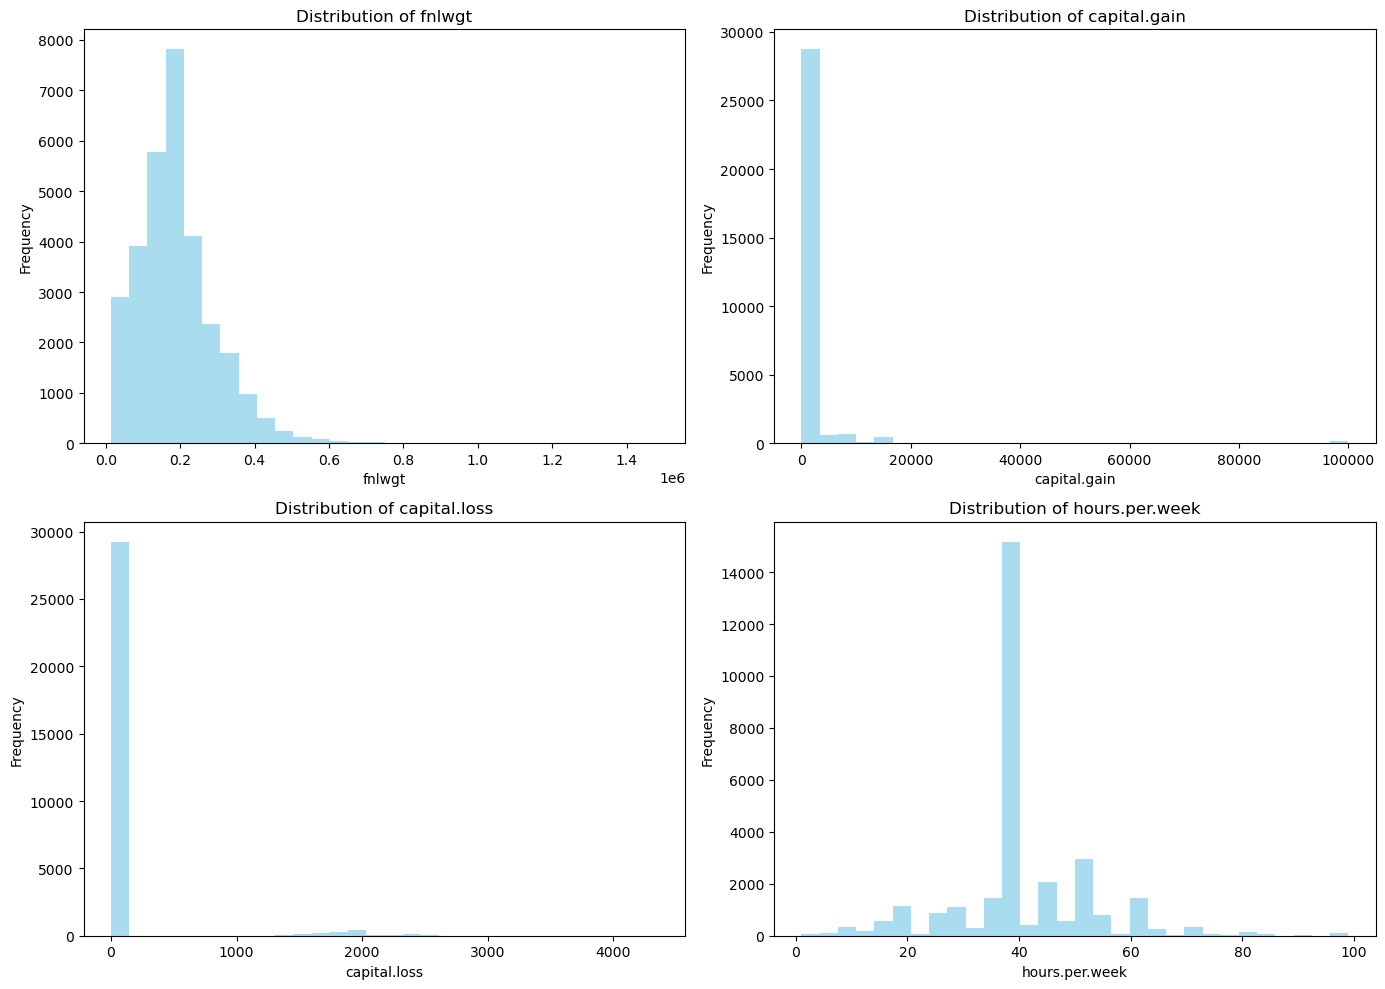

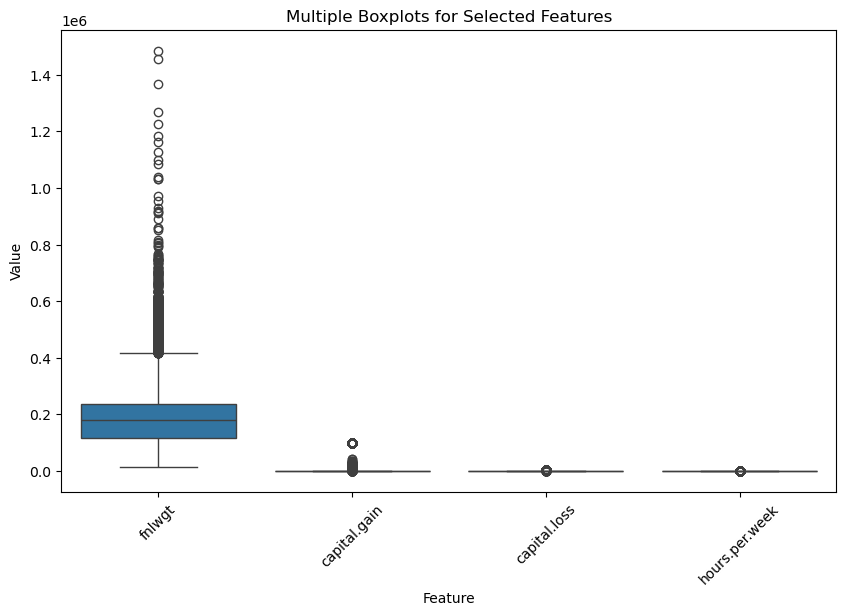

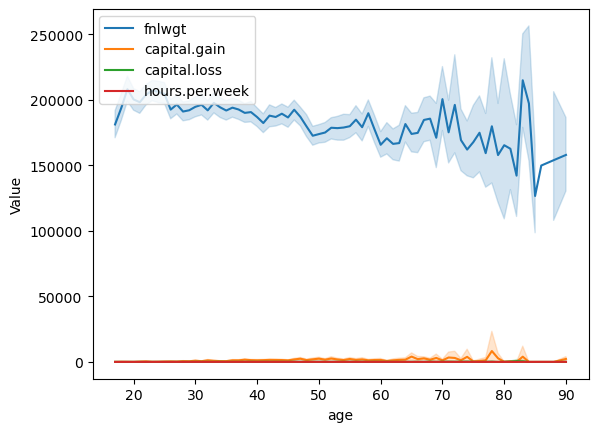

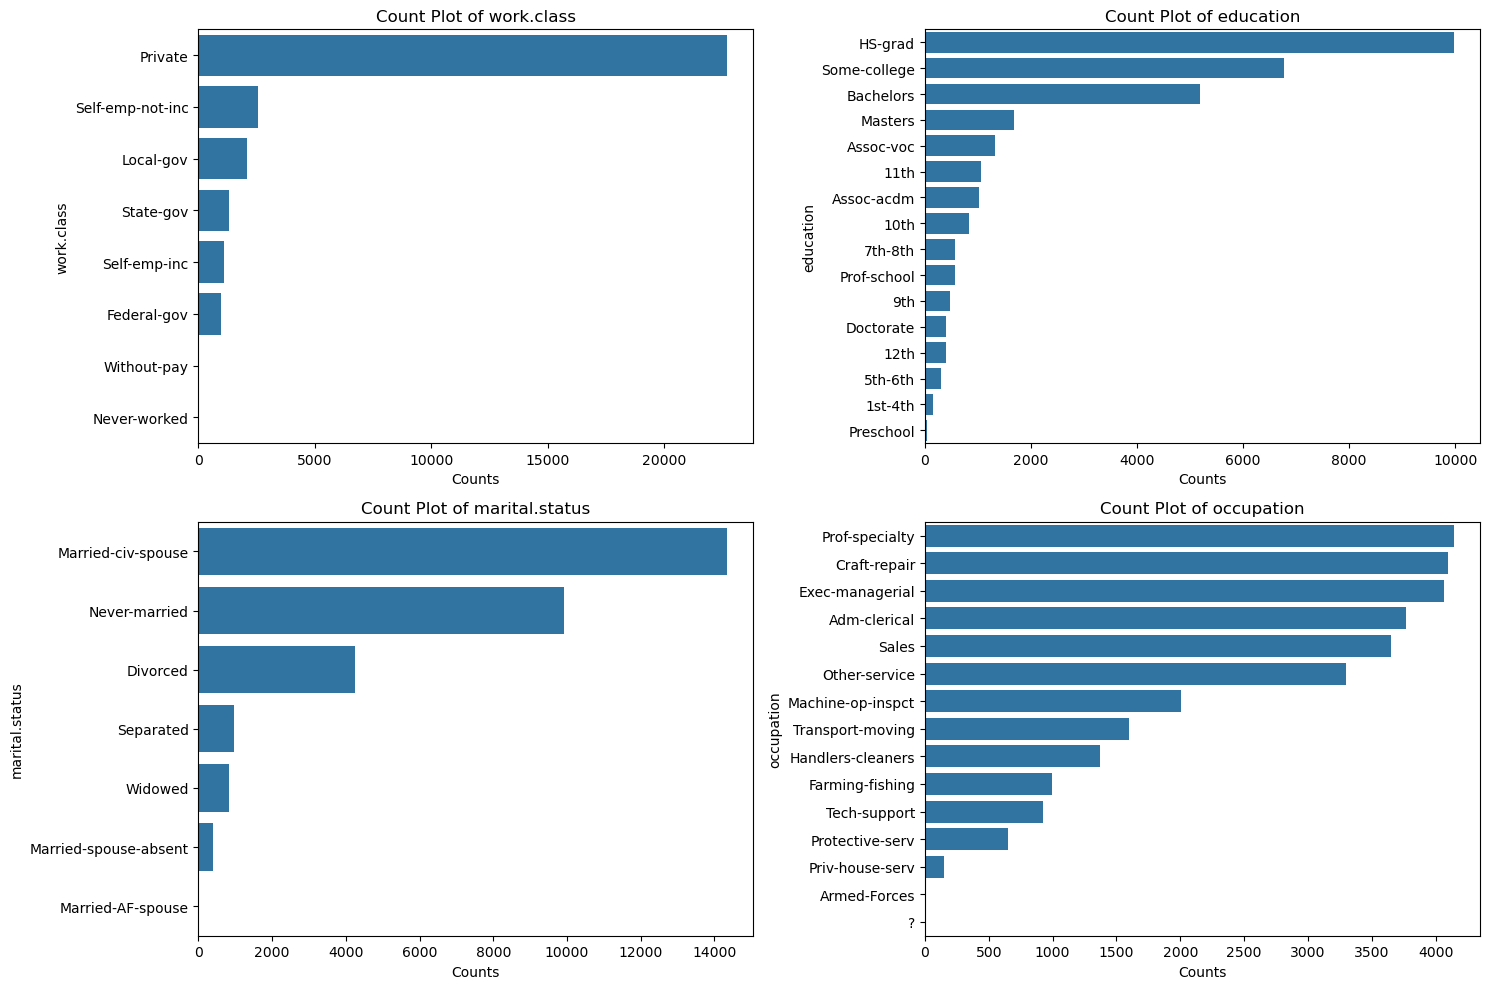

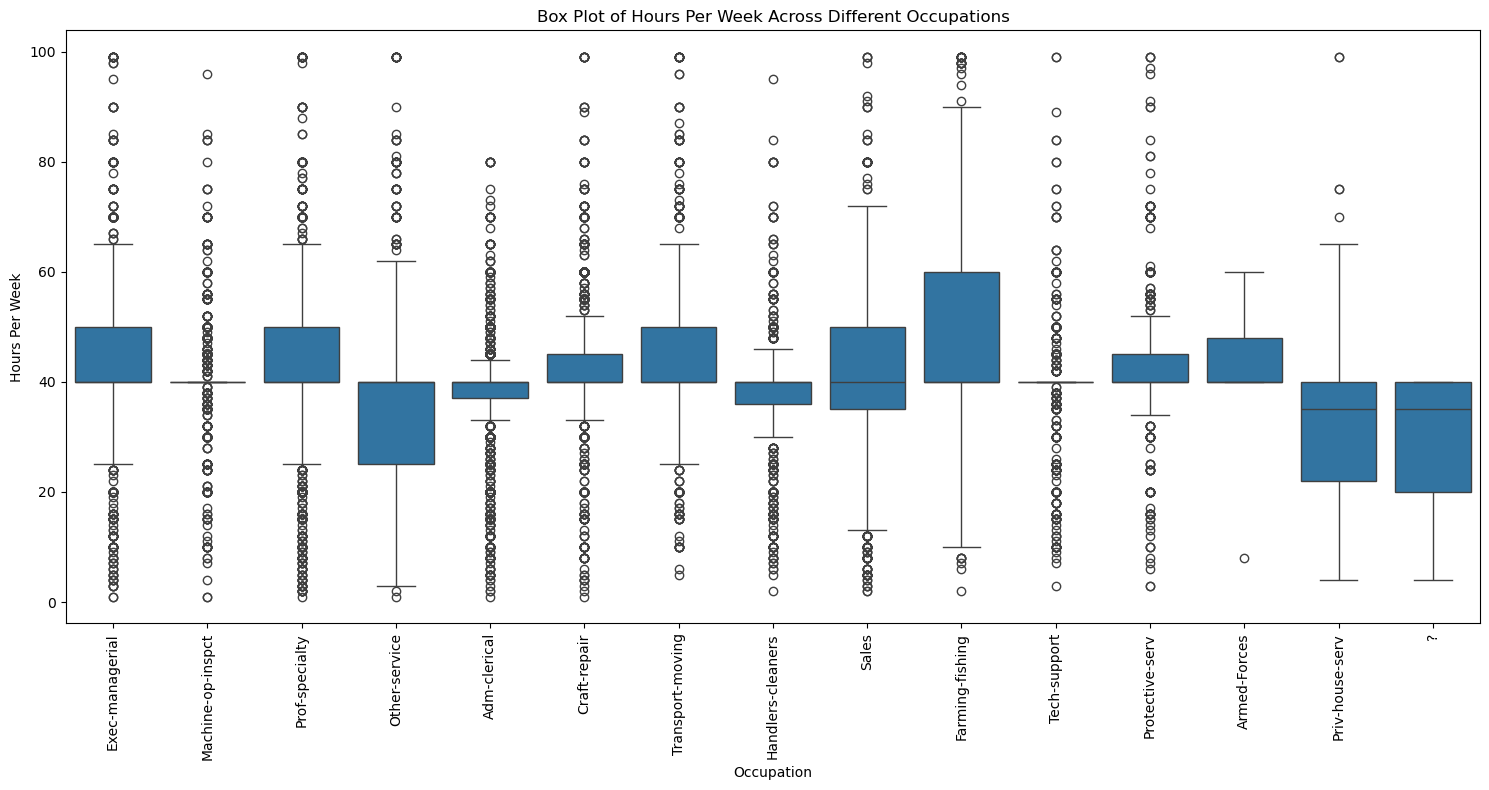

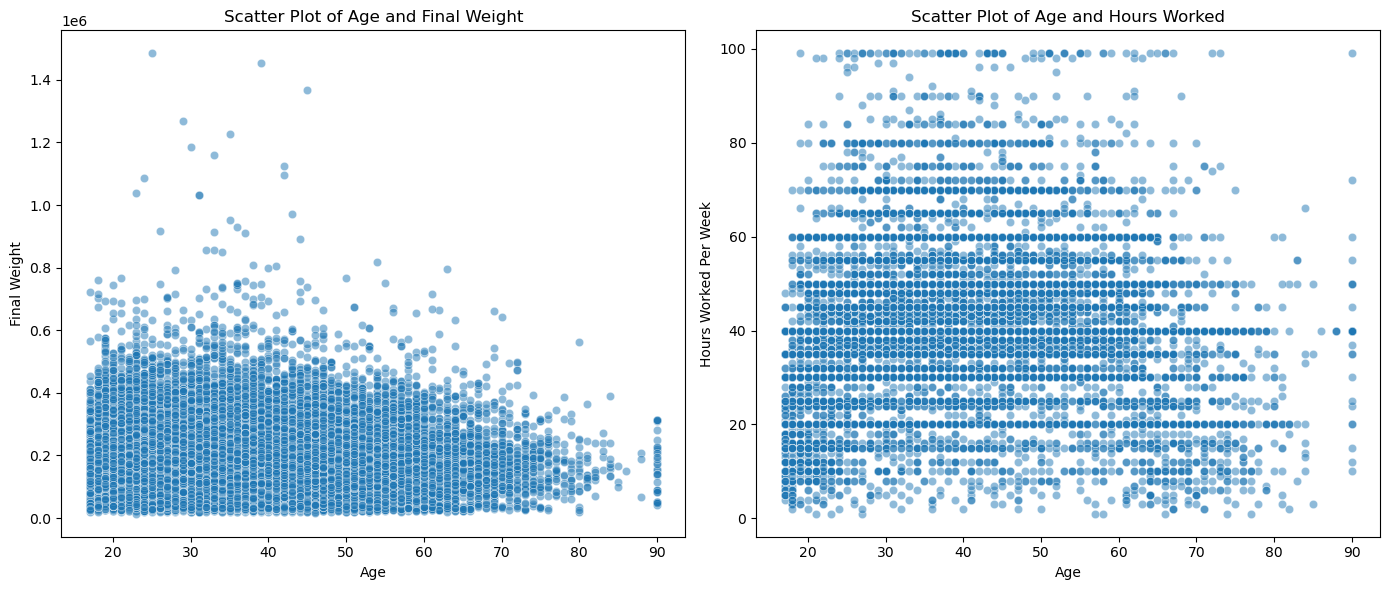

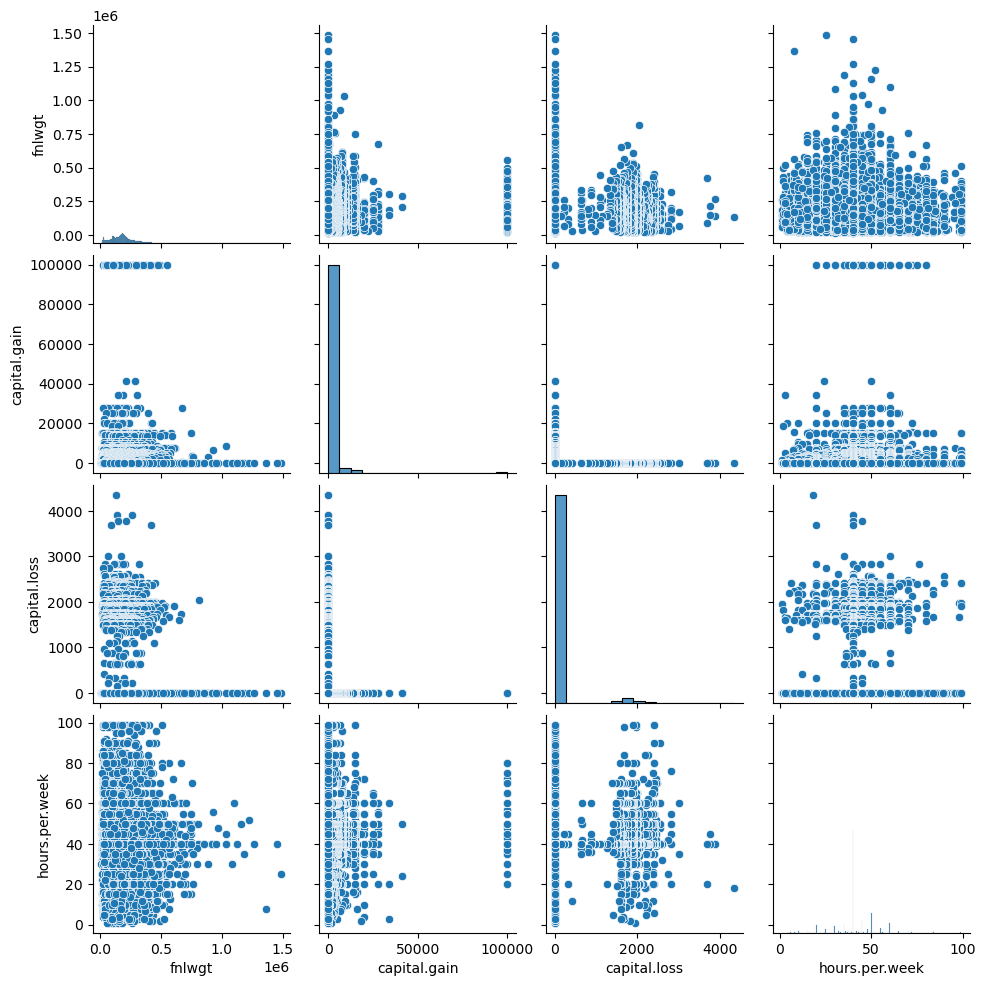

In [21]:
#Univariate analysis

for column in columns_to_check:
    data = df[column]

    # Central Tendency
    mean_value = data.mean()
    median_value = data.median()
    mode_value = data.mode()[0]  # mode() returns a Series; index [0] gets the mode value if there is one

    # Variability
    range_value = data.max() - data.min()
    variance_value = data.var()
    std_deviation_value = data.std()
    iqr_value = data.quantile(0.75) - data.quantile(0.25)

    # Printing the data
    print(f"Column: {column}")
    print(f"  Mean: {mean_value}")
    print(f"  Median: {median_value}")
    print(f"  Mode: {mode_value}")
    print(f"  Range: {range_value}")
    print(f"  Variance: {variance_value}")
    print(f"  Standard Deviation: {std_deviation_value}")
    print(f"  Interquartile Range: {iqr_value}\n")

# Assuming 'df' is your DataFrame and we're creating histograms for the specified columns
columns_to_check = ['fnlwgt', 'capital.gain', 'capital.loss', 'hours.per.week']

# Set up the figure size and layout
plt.figure(figsize=(14, 10))
for index, column in enumerate(columns_to_check, 1):  # Enumerate to access index for subplotting
    plt.subplot(2, 2, index)  # 2 rows, 2 columns, current index position
    plt.hist(df[column], bins=30, color='skyblue', alpha=0.7)
    plt.title(f'Distribution of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')

plt.tight_layout()  # Adjust subplots to fit into figure area.
plt.show()



# Melting the dataframe to long format for the specified columns to be suitable for sns.boxplot
df_long = pd.melt(df, value_vars=columns_to_check, var_name='Feature', value_name='Value')

# Creating the boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x='Feature', y='Value', data=df_long)

# Setting the title and labels for readability
plt.title('Multiple Boxplots for Selected Features')
plt.xlabel('Feature')
plt.ylabel('Value')
plt.xticks(rotation=45)  # Rotate x labels for better readability
plt.show()



df_long = df.melt(id_vars='age', value_vars=columns_to_check, var_name='Feature', value_name='Value')

sns.lineplot(data=df_long, x='age', y='Value', hue='Feature')

plt.legend(loc="upper left")
plt.show()



# List of categorical columns to visualize with count plots
categorical_columns = ['work.class', 'education', 'marital.status', 'occupation']

# Set up the matplotlib figure - change figsize if needed
plt.figure(figsize=(15, 10))

# Create a count plot for each categorical variable
for index, column in enumerate(categorical_columns, 1):
    plt.subplot(2, 2, index)  # 2 rows, 2 columns, subplot index
    sns.countplot(y=column, data=df, order=df[column].value_counts().index)
    plt.title(f'Count Plot of {column}')
    plt.xlabel('Counts')
    plt.ylabel(column)
    plt.tight_layout()

plt.show()

# Creating box plots for 'hours.per.week' across different 'occupation' categories
plt.figure(figsize=(15, 8))
sns.boxplot(x='occupation', y='hours.per.week', data=df)

plt.title('Box Plot of Hours Per Week Across Different Occupations')
plt.xlabel('Occupation')
plt.ylabel('Hours Per Week')
plt.xticks(rotation=90)  # Rotate the x labels for better readability
plt.tight_layout()  # Adjust layout
plt.show()


# Set up the matplotlib figure
plt.figure(figsize=(14, 6))

# Scatter plot for 'age' and 'fnlwgt'
plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
sns.scatterplot(x='age', y='fnlwgt', data=df, alpha=0.5)
plt.title('Scatter Plot of Age and Final Weight')
plt.xlabel('Age')
plt.ylabel('Final Weight')

# Scatter plot for 'age' and 'hours worked per week'
plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
sns.scatterplot(x='age', y='hours.per.week', data=df, alpha=0.5)
plt.title('Scatter Plot of Age and Hours Worked')
plt.xlabel('Age')
plt.ylabel('Hours Worked Per Week')

plt.tight_layout()  # Adjust subplots to fit into figure area.
plt.show()


# List of numerical columns for which to create a pairs plot
numerical_columns = ['fnlwgt', 'capital.gain', 'capital.loss', 'hours.per.week']

# Create a pairplot for the numerical columns
sns.pairplot(df[numerical_columns])

# Show the plot
plt.show()

# The dataset's summary statistics reveal key insights. The fnlwgt feature shows substantial 
# variability with a mean of 189,853.78 and high standard deviation, indicating a right-skewed 
# distribution. Both capital.gain and capital.loss have medians and modes of 0, suggesting most 
# individuals report no gains or losses, though a few have exceptionally high values contributing 
# to high variability. The hours.per.week feature shows most individuals work around 40 hours per 
# week, with minimal variability. These insights are essential for understanding data distribution 
# and informing modeling decisions.


# The histograms provide visual insights into the distribution of key numerical features in the dataset.
# 
# 1. Distribution of fnlwgt:
#    - The fnlwgt (final weight) feature shows a right-skewed distribution with a concentration of values at the lower end.
#    - The majority of individuals have fnlwgt values below 0.4 million, with a long tail extending to over 1.4 million.
#    - This confirms the substantial variability indicated by the high standard deviation and range.
# 
# 2. Distribution of capital.gain:
#    - The capital.gain feature is highly right-skewed, with most values at 0 and a few exceptionally high values.
#    - This aligns with the summary statistics, showing a high mean and standard deviation driven by outliers.
# 
# 3. Distribution of capital.loss:
#    - Similar to capital.gain, the capital.loss feature is highly right-skewed with most values at 0.
#    - A small number of individuals report significant capital losses, contributing to the variability.
# 
# 4. Distribution of hours.per.week:
#    - The hours.per.week feature has a peak around 40 hours, indicating that most individuals work a standard full-time schedule.
#    - The distribution shows some variability, with a range extending up to 98 hours per week.
# 
# These insights confirm the findings from the summary statistics, highlighting the skewness and variability in the data,
# which are important considerations for further analysis and modeling.




# The boxplots provide visual insights into the distributions and outliers for key numerical features in the dataset.
#
# 1. fnlwgt:
#    - The boxplot for fnlwgt (final weight) shows a significant number of outliers above the upper whisker.
#    - The central 50% of the data (IQR) is concentrated between approximately 100,000 and 300,000.
#    - The presence of many outliers confirms the high variability and right-skewness observed in the summary statistics.
#
# 2. capital.gain:
#    - The boxplot for capital.gain shows that most values are at 0, with a few significant outliers.
#    - These outliers extend far above the upper whisker, indicating a highly skewed distribution.
#    - This aligns with the summary statistics and histogram, where most individuals report no capital gain.
#
# 3. capital.loss:
#    - Similar to capital.gain, the boxplot for capital.loss shows most values at 0, with a few outliers.
#    - The outliers extend above the upper whisker, indicating a skewed distribution with rare but significant capital losses.
#
# 4. hours.per.week:
#    - The boxplot for hours.per.week shows most values around 40 hours per week, with a few outliers.
#    - The distribution is relatively symmetric with a narrow IQR, indicating low variability around the median.
#    - The outliers at the higher end represent individuals working significantly more than the typical full-time schedule.
#
# These boxplots confirm the findings from the summary statistics and histograms, highlighting the presence of outliers and the variability in the data. This information is crucial for understanding the data distribution and identifying potential issues for modeling.


# The line plot provides visual insights into the relationship between age and key numerical features in the dataset.
#
# 1. fnlwgt:
#    - The fnlwgt (final weight) shows a general increase with age, with some fluctuations.
#    - The shaded area represents the variability, which increases with age, especially after 70.
#    - This suggests that older individuals tend to have higher and more variable final weights.
#
# 2. capital.gain:
#    - The capital.gain feature remains mostly flat across ages, with occasional small peaks.
#    - This indicates that capital gains are not significantly influenced by age for most individuals.
#    - The variability (shaded area) is minimal, reflecting that the majority of values are zero with few exceptions.
#
# 3. capital.loss:
#    - Similar to capital.gain, the capital.loss feature shows minimal variation with age.
#    - The line stays close to zero across all ages, with few peaks and low variability.
#    - This suggests that capital losses are also not significantly influenced by age.
#
# 4. hours.per.week:
#    - The hours.per.week feature shows a slight decline with age, especially noticeable after age 60.
#    - The variability remains low, indicating consistent work hours for most age groups.
#    - This pattern reflects typical retirement trends and reduced working hours in older individuals.
#
# These insights help understand how different numerical features relate to age, highlighting that while fnlwgt varies significantly with age, capital.gain and capital.loss remain relatively constant, and hours.per.week decrease slightly in older age groups.


# The pair plot provides visual insights into the relationships and distributions of key numerical features in the dataset.
#
# 1. fnlwgt:
#    - The scatter plots involving fnlwgt show a wide spread of values, confirming its high variability.
#    - No strong linear relationships are evident between fnlwgt and other features (capital.gain, capital.loss, hours.per.week).
#
# 2. capital.gain:
#    - The scatter plots for capital.gain show a cluster of values at 0, with a few high values scattered, indicating outliers.
#    - There are no clear relationships between capital.gain and other features.
#
# 3. capital.loss:
#    - Similar to capital.gain, capital.loss also shows a cluster at 0 with few high values indicating outliers.
#    - The scatter plots do not reveal any strong relationships with other features.
#
# 4. hours.per.week:
#    - The scatter plots for hours.per.week show a concentration around 40 hours, confirming the standard full-time work week for most individuals.
#    - There are no strong relationships between hours.per.week and other features.
#
# Diagonal Plots:
#    - The diagonal plots show the distribution of each feature. fnlwgt has a right-skewed distribution, while capital.gain and capital.loss are heavily right-skewed with most values at 0.
#    - hours.per.week has a relatively symmetrical distribution around 40 hours.
#
# These insights confirm the lack of strong linear relationships between the features, highlighting the need for careful feature selection and engineering in modeling.




Handling outliers + Data Duplication

In [22]:

def remove_outliers(df, features):

    #Remove outliers from the DataFrame using the Interquartile Range (IQR) method.
   
    for col in features:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # Filter out the outliers from the DataFrame
        df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
    
    return df
df = remove_outliers(df, columns_to_check)
number_of_entries_after_outliers_removed = df.shape[0]
print(f"Number of entries after removing outliers: {number_of_entries_after_outliers_removed}")

# Check for duplicate rows in the DataFrame
duplicates = df.duplicated()

# Count the number of duplicate rows
number_of_duplicates = duplicates.sum()
print(f"Number of duplicate entries in the dataset: {number_of_duplicates}")

# Drop duplicate rows from the DataFrame
df = df.drop_duplicates()

# Verify that duplicates have been removed
duplicates_after_dropping = df.duplicated().sum()
print(f"Number of duplicate entries after dropping duplicates: {duplicates_after_dropping}")

#Scaling numerical features

# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Apply the scaler to the numerical columns
df[numerical_columns] = scaler.fit_transform(df[numerical_columns])

# Display the first few rows of the scaled DataFrame
display(df.head())




#Small Amount of duplicate data drop them.


Number of entries after removing outliers: 18961
Number of duplicate entries in the dataset: 18
Number of duplicate entries after dropping duplicates: 0


,age,work.class,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
4232,38,Private,0.499999,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.0,0.0,0.368421,United-States,<=50K
4233,53,Private,0.547504,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.0,0.0,0.368421,United-States,<=50K
4234,28,Private,0.805731,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.0,0.0,0.368421,Cuba,<=50K
4235,37,Private,0.671679,Masters,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,0.0,0.0,0.368421,United-States,<=50K
4237,52,Self-emp-not-inc,0.485046,HS-grad,9,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,0.631579,United-States,>50K


Data Preprocessing

In [23]:
# Label Encoding for categorical variables
label_encoder = LabelEncoder()
categorical_cols = ['work.class', 'education', 'marital.status', 'occupation', 'relationship', 'race', 'sex', 'native.country']

for col in categorical_cols:
    df[col] = label_encoder.fit_transform(df[col])

# Display the first few rows of the encoded DataFrame
print("Shape after encoding:", df.shape)
display(df.head())

#Perform Feature Extraction
df['net.capital.gain'] = df['capital.gain'] - df['capital.loss']

#binning age group
df['age.group'] = pd.cut(df['age'], bins=[0, 25, 45, 65, 100], labels=['Young', 'Adult', 'Senior', 'Elder'])

# Drop unnecessary columns
df.drop(columns=['capital.gain', 'capital.loss'], inplace=True)

# Apply Label Encoding to the 'age.group' column
df['age.group'] = label_encoder.fit_transform(df['age.group'])

# Display the first few rows of the final DataFrame
print("Shape after feature extraction and removal:", df.shape)
display(df.head())


# Feature Extraction:
# - A new feature 'net.capital.gain' was created by subtracting 'capital.loss' from 'capital.gain'.
# - This new feature represents the net capital gain/loss, potentially providing more meaningful insights than separate gain and loss columns.
#
# Binning Age Groups:
# - The 'age' column was binned into four age groups: 'Young', 'Adult', 'Senior', 'Elder' using the pd.cut() function.
# - Binning helps in reducing the variability of continuous data and can improve model performance by introducing non-linearity.
#
# Drop Unnecessary Columns:
# - The original 'capital.gain' and 'capital.loss' columns were dropped as their information is now captured in 'net.capital.gain'.
#
# Apply Label Encoding to Age Groups:
# - The 'age.group' column was also label encoded, transforming the age categories into numerical values.


# Insights:
# - The choice of label encoding is straightforward and effective for converting categorical data into a format suitable for machine learning algorithms.
# - Creating a net capital gain feature and binning age groups helps in capturing more nuanced relationships within the data.
# - Dropping redundant columns ensures a cleaner dataset with reduced dimensionality, facilitating more efficient modeling.







Shape after encoding: (18943, 15)


,age,work.class,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
4232,38,3,0.499999,11,9,0,6,1,4,1,0.0,0.0,0.368421,37,<=50K
4233,53,3,0.547504,1,7,2,6,0,2,1,0.0,0.0,0.368421,37,<=50K
4234,28,3,0.805731,9,13,2,10,5,2,0,0.0,0.0,0.368421,4,<=50K
4235,37,3,0.671679,12,14,2,4,5,4,0,0.0,0.0,0.368421,37,<=50K
4237,52,5,0.485046,11,9,2,4,0,4,1,0.0,0.0,0.631579,37,>50K


Shape after feature extraction and removal: (18943, 15)


,age,work.class,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,hours.per.week,native.country,income,net.capital.gain,age.group
4232,38,3,0.499999,11,9,0,6,1,4,1,0.368421,37,<=50K,0.0,0
4233,53,3,0.547504,1,7,2,6,0,2,1,0.368421,37,<=50K,0.0,2
4234,28,3,0.805731,9,13,2,10,5,2,0,0.368421,4,<=50K,0.0,0
4235,37,3,0.671679,12,14,2,4,5,4,0,0.368421,37,<=50K,0.0,0
4237,52,5,0.485046,11,9,2,4,0,4,1,0.631579,37,>50K,0.0,2


Building a decision tree and optimizing it with Pruning

Training set shape: (15154, 14)
Testing set shape: (3789, 14)


,age,work.class,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,hours.per.week,native.country,net.capital.gain,age.group
8741,51,4,0.377320,9,13,2,4,5,1,0,0.105263,34,0.0,2
6285,25,3,0.491671,15,10,5,1,4,4,0,0.368421,37,0.0,3
21464,53,3,0.434911,11,9,2,3,0,4,1,0.368421,37,0.0,2
7882,24,3,0.660602,0,6,4,12,1,4,1,0.842105,7,0.0,3
27309,23,3,0.335775,11,9,4,1,3,4,0,0.368421,37,0.0,3


8741     <=50K
6285     <=50K
21464    <=50K
7882     <=50K
27309    <=50K
Name: income, dtype: object

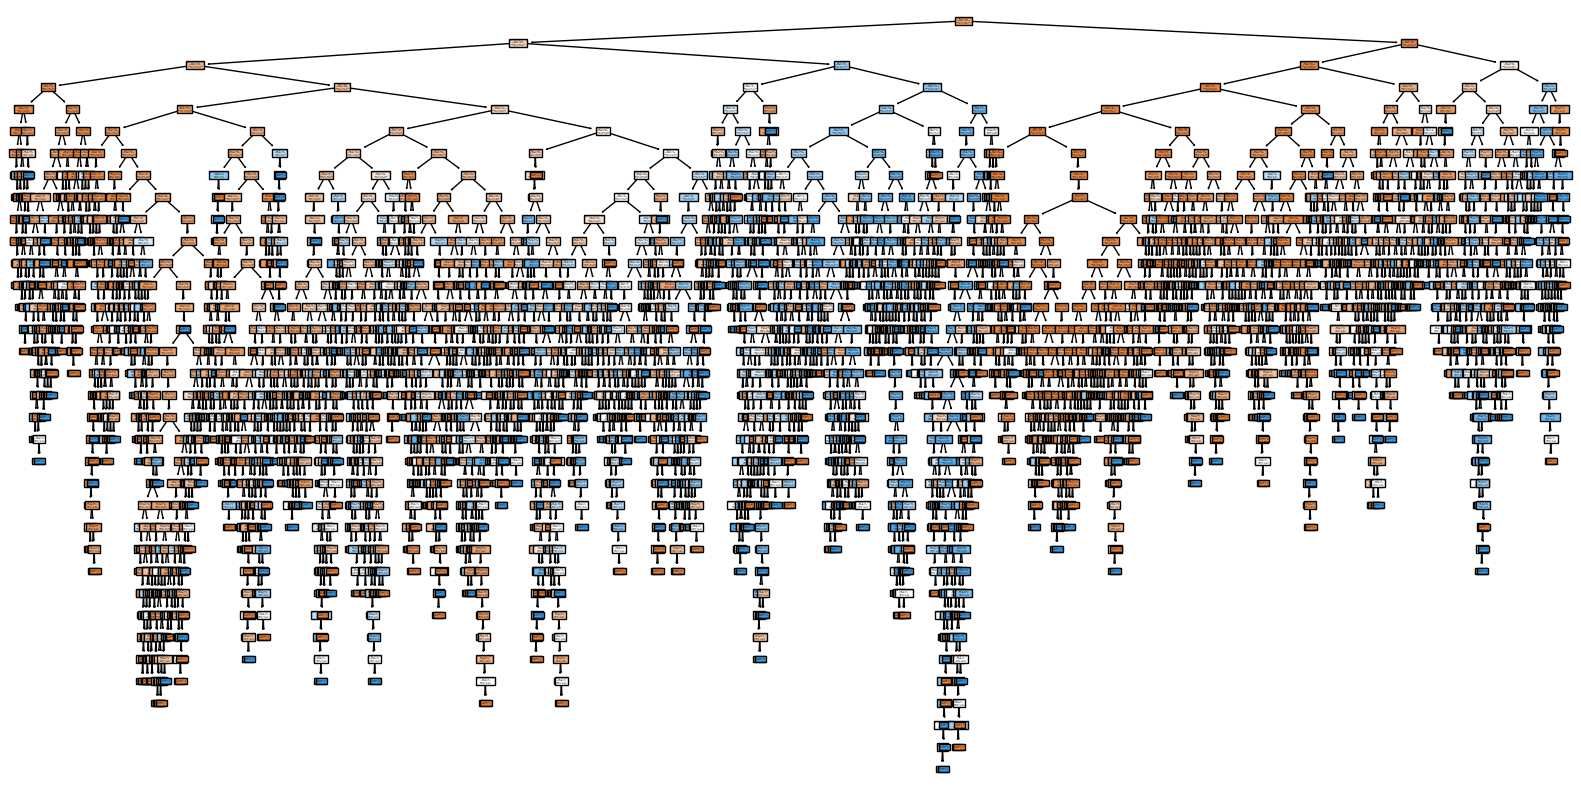

Training Accuracy of the Decision Tree model: 1.0
Testing Accuracy of the Decision Tree model: 0.7706518870414357


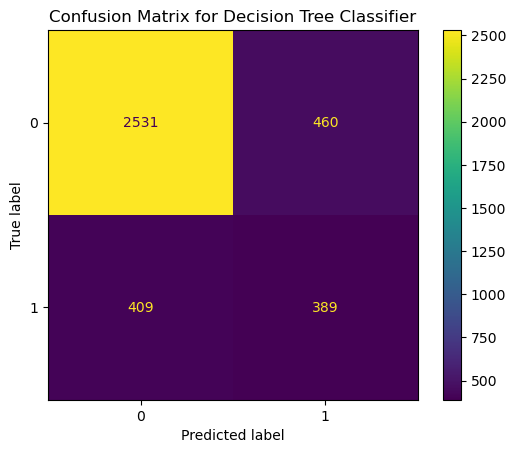

Classification Report:
              precision    recall  f1-score   support

       <=50K       0.86      0.85      0.85      2991
        >50K       0.46      0.49      0.47       798

    accuracy                           0.77      3789
   macro avg       0.66      0.67      0.66      3789
weighted avg       0.78      0.77      0.77      3789

Best parameters found:  {'max_depth': 7, 'min_samples_leaf': 4, 'min_samples_split': 2}
Training Accuracy of the pruned Decision Tree model: 0.8465751616734856
Testing Accuracy of the pruned Decision Tree model: 0.8302982317234099


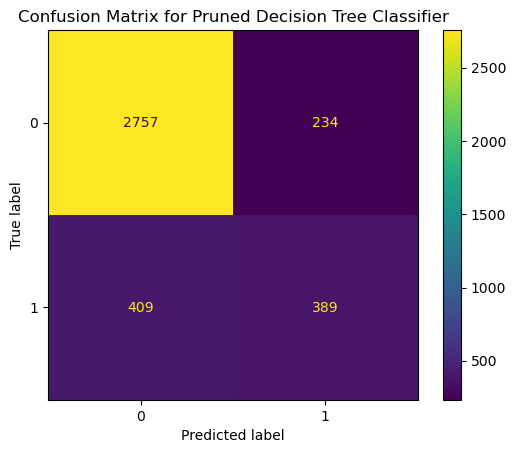

Classification Report for Pruned Model:
              precision    recall  f1-score   support

       <=50K       0.87      0.92      0.90      2991
        >50K       0.62      0.49      0.55       798

    accuracy                           0.83      3789
   macro avg       0.75      0.70      0.72      3789
weighted avg       0.82      0.83      0.82      3789



In [24]:
# Define X and y
X = df.drop(columns=['income'])
y = df['income']

# Split the dataset into training and testing sets using stratified sampling
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Display the shapes of the training and testing sets
print(f"Training set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")

# Display the first few rows of the training set
display(X_train.head())
display(y_train.head())


# Train a Decision Tree model
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train, y_train)

# Plot the Decision Tree
plt.figure(figsize=(20, 10))
plot_tree(dt_model, filled=True, feature_names=X.columns, class_names=y.unique())
plt.show()

# Make predictions on the testing set
y_pred = dt_model.predict(X_test)

# Report the training accuracy
training_accuracy = dt_model.score(X_train, y_train)
print(f"Training Accuracy of the Decision Tree model: {training_accuracy}")

# Report the testing accuracy
testing_accuracy = accuracy_score(y_test, y_pred)
print(f"Testing Accuracy of the Decision Tree model: {testing_accuracy}")

# Display the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(confusion_matrix=conf_matrix).plot()
plt.title("Confusion Matrix for Decision Tree Classifier")
plt.show()

# Display the classification report
class_report = classification_report(y_test, y_pred)
print("Classification Report:")
print(class_report)



# Define the parameter grid
param_grid = {
    'max_depth': [3, 5, 7, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}

# Initialize the Decision Tree classifier
dt = DecisionTreeClassifier(random_state=42)

# Initialize GridSearchCV with 5-fold cross-validation
grid_search = GridSearchCV(estimator=dt, param_grid=param_grid, cv=5, n_jobs=-1, scoring='accuracy')

# Fit GridSearchCV to the data
grid_search.fit(X_train, y_train)

# Get the best parameters from GridSearchCV
best_params = grid_search.best_params_
print("Best parameters found: ", best_params)

# Train the Decision Tree model with the best parameters
dt_best = DecisionTreeClassifier(**best_params, random_state=42)
dt_best.fit(X_train, y_train)

# Evaluate the pruned model
training_accuracy = dt_best.score(X_train, y_train)
testing_accuracy = dt_best.score(X_test, y_test)
y_pred_best = dt_best.predict(X_test)

print(f"Training Accuracy of the pruned Decision Tree model: {training_accuracy}")
print(f"Testing Accuracy of the pruned Decision Tree model: {testing_accuracy}")

# Display the confusion matrix for the pruned model
conf_matrix_best = confusion_matrix(y_test, y_pred_best)
ConfusionMatrixDisplay(confusion_matrix=conf_matrix_best).plot()
plt.title("Confusion Matrix for Pruned Decision Tree Classifier")
plt.show()

# Display the classification report for the pruned model
class_report_best = classification_report(y_test, y_pred_best)
print("Classification Report for Pruned Model:")
print(class_report_best)








# Confusion Matrix for Decision Tree Classifier:
# - The confusion matrix reveals the performance of the Decision Tree model on the testing set.
# - True Negatives (0, 0): 2,531
# - False Positives (0, 1): 460
# - False Negatives (1, 0): 409
# - True Positives (1, 1): 389
# - Most misclassifications occur for the '>50K' class, indicating that the model struggles more with identifying higher income individuals.

# Training and Testing Accuracy:
# - Training Accuracy: 1.0 (100%)
# - Testing Accuracy: 0.77 (77%)
# - The model perfectly fits the training data but shows reduced accuracy on the testing data, suggesting overfitting.

# Classification Report:
# - Precision, Recall, F1-Score for <=50K: 0.86, 0.85, 0.85
# - Precision, Recall, F1-Score for >50K: 0.46, 0.49, 0.47
# - Overall Accuracy: 0.77
# - Macro Avg (Precision, Recall, F1-Score): 0.66, 0.67, 0.66
# - Weighted Avg (Precision, Recall, F1-Score): 0.78, 0.77, 0.77
# - The model performs well in predicting lower income (<=50K) but struggles with higher income (>50K), as indicated by lower precision and recall for the >50K class.

# Strengths:
# - High precision, recall, and F1-score for the <=50K class, indicating reliable performance for the majority class.
# - Good overall accuracy (77%) on the testing set.

# Weaknesses:
# - Significant overfitting is evident from the perfect training accuracy and lower testing accuracy.
# - Poor performance in predicting the >50K class, with low precision (0.46) and recall (0.49).

# Areas for Improvement:
# - Apply techniques to reduce overfitting, such as pruning the Decision Tree or using ensemble methods like Random Forest.
# - Perform hyperparameter tuning to improve generalization.
# - Consider balancing the dataset or using weighted classes to address the imbalance between <=50K and >50K classes.
# - Explore additional features or feature engineering to improve model performance for higher income predictions.






# The pruned Decision Tree model shows improved overall accuracy (83%) and reduced overfitting 
# compared to the unpruned model, as indicated by fewer false positives and a higher precision 
# for the <=50K class. This pruning process has enhanced the model's generalization ability, 
# making it more reliable for real-world predictions while still requiring further refinement 
# to better classify the >50K income group.


Creating a Random Forest and Optimizing GridSearchCV

In [25]:
# Train an initial Random Forest to get feature importances
initial_rf = RandomForestClassifier(n_estimators=100, random_state=42)
initial_rf.fit(X_train, y_train)

# Feature Importance using Random Forest
importances = initial_rf.feature_importances_
indices = np.argsort(importances)[::-1]

# Print feature ranking
print("Feature ranking:")
for f in range(X_train.shape[1]):
    print(f"{f + 1}. feature {indices[f]} ({importances[indices[f]]}) - {X.columns[indices[f]]}")

# Select top N features (for example, top 10 features)
N = 10
top_features = X.columns[indices[:N]]
X_train_top = X_train[top_features]
X_test_top = X_test[top_features]

# Hyperparameter tuning with GridSearchCV for Random Forest
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_samples': [0.5, 0.75, 1.0],
    'max_depth': [3, 5, 7, 10, None],
}

grid_search_rf = GridSearchCV(estimator=RandomForestClassifier(random_state=42), param_grid=param_grid_rf, cv=5, n_jobs=-1, scoring='accuracy')
grid_search_rf.fit(X_train_top, y_train)

# Get the best parameters and train the Random Forest model
best_params_rf = grid_search_rf.best_params_
print("Best parameters for Random Forest: ", best_params_rf)

random_forest_best = RandomForestClassifier(**best_params_rf, random_state=42)
random_forest_best.fit(X_train_top, y_train)

# Evaluate the optimized Random Forest model with top features
training_accuracy_rf = random_forest_best.score(X_train_top, y_train)
testing_accuracy_rf = random_forest_best.score(X_test_top, y_test)
y_pred_rf = random_forest_best.predict(X_test_top)

print(f"Training Accuracy of the optimized Random Forest model: {training_accuracy_rf}")
print(f"Testing Accuracy of the optimized Random Forest model: {testing_accuracy_rf}")

# Cross-validation for the Random Forest model
cv_scores = cross_val_score(random_forest_best, X_train_top, y_train, cv=5)

# Output the results
print(f"Cross-Validation Scores: {cv_scores}")
print(f"Mean CV Score: {cv_scores.mean():.2f}")
print(f"Standard Deviation CV Score: {cv_scores.std():.2f}")

# Compare the performance of the Decision Tree and the Random Forest model
dt_accuracy = accuracy_score(y_test, dt_model.predict(X_test))
rf_accuracy = testing_accuracy_rf
print(f"\nDecision Tree Accuracy: {dt_accuracy:.2f}")
print(f"Random Forest Accuracy: {rf_accuracy:.2f}")

if rf_accuracy > dt_accuracy:
    print("The Random Forest model outperforms the Decision Tree model.")
else:
    print("The Decision Tree model outperforms the Random Forest model.")







# Feature Ranking Insights:
# 1. Feature Importance:
#    - The most important features are fnlwgt, age, relationship, education.num, and occupation, indicating they have the highest impact on the model's predictions.
#    - Features like sex, race, and net.capital.gain have the least importance, suggesting they contribute minimally to the model.
# 
# 2. Best Parameters for Random Forest:
#    - max_depth: 10, max_samples: 0.75, n_estimators: 200
#    - These parameters were selected through hyperparameter tuning to optimize model performance.
#
# 3. Model Performance:
#    - Training Accuracy of the optimized Random Forest model: 87.08%
#    - Testing Accuracy of the optimized Random Forest model: 84.24%
#    - Cross-Validation Scores: [0.8439, 0.8423, 0.8423, 0.8413, 0.8465] with a mean CV score of 84% and a standard deviation of 0.00.
#    - The consistency in cross-validation scores indicates robust model performance across different data splits.
# 
# Comparison with Decision Tree:
# - Decision Tree Accuracy: 77%
# - Random Forest Accuracy: 84%
# - The Random Forest model outperforms the Decision Tree model, showing higher accuracy and better generalization.

# Strengths:
# - The Random Forest model demonstrates strong performance with high training and testing accuracy, and low variance in cross-validation scores.
# - Feature importance analysis helps in understanding which features drive the model's decisions, aiding in feature engineering and selection.
# - The hyperparameter-tuned model provides optimized performance, balancing bias and variance effectively.

# Weaknesses:
# - While the Random Forest model performs better, it still has room for improvement in handling less important features like net.capital.gain and sex.
# - There may be potential overfitting as indicated by the slight difference between training and testing accuracy.

# Areas for Improvement:
# - Further feature engineering could improve the model by exploring interactions between top-ranked features or creating new composite features.
# - Addressing class imbalance through techniques like SMOTE or adjusting class weights could enhance the model's performance on minority classes.
# - Continued hyperparameter tuning and experimenting with different model architectures, such as Gradient Boosting Machines (GBM), could yield better results.
# - Reducing model complexity and feature selection could help in addressing overfitting and improving generalization further.


Feature ranking:
1. feature 2 (0.22950866455012986) - fnlwgt
2. feature 0 (0.16797760178057242) - age
3. feature 7 (0.10994845459608146) - relationship
4. feature 4 (0.09825036748497995) - education.num
5. feature 6 (0.09460791944221782) - occupation
6. feature 5 (0.06281806040602861) - marital.status
7. feature 10 (0.06062392143595693) - hours.per.week
8. feature 1 (0.0516323032273142) - work.class
9. feature 3 (0.045586281801694266) - education
10. feature 13 (0.024594928083101947) - age.group
11. feature 11 (0.01983487123630461) - native.country
12. feature 8 (0.01914152555742197) - race
13. feature 9 (0.015475100398196018) - sex
14. feature 12 (0.0) - net.capital.gain
Best parameters for Random Forest:  {'max_depth': 10, 'max_samples': 0.75, 'n_estimators': 200}
Training Accuracy of the optimized Random Forest model: 0.8707931899168536
Testing Accuracy of the optimized Random Forest model: 0.8424386381631037
Cross-Validation Scores: [0.84394589 0.84229627 0.84229627 0.8413065  0.84

Deep Learning Model - Neural Network ( Using Pytorch )

In [26]:
# Ensure y_train and y_test are encoded as integers
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Convert DataFrame to PyTorch tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_encoded, dtype=torch.long)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_encoded, dtype=torch.long)

# Create DataLoader for batching
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Define the neural network model
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.relu2(out)
        out = self.fc3(out)
        return out

# Initialize the model, loss function, and optimizer
input_size = X_train.shape[1]
hidden_size = 100
num_classes = len(label_encoder.classes_)

model = NeuralNetwork(input_size, hidden_size, num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the neural network
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    for inputs, labels in train_loader:
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

# Evaluate the neural network
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    nn_accuracy = correct / total
    print(f"Neural Network Accuracy: {nn_accuracy:.4f}")

# Compare the performance with Decision Tree and Random Forest
print(f"\nDecision Tree Accuracy: {dt_accuracy:.2f}")
print(f"Random Forest Accuracy: {rf_accuracy:.2f}")
print(f"Neural Network Accuracy: {nn_accuracy:.2f}")

if nn_accuracy > max(dt_accuracy, rf_accuracy):
    print("The Neural Network model outperforms the Decision Tree and Random Forest models.")
elif rf_accuracy > max(dt_accuracy, nn_accuracy):
    print("The Random Forest model outperforms the Decision Tree and Neural Network models.")
else:
    print("The Decision Tree model outperforms the Random Forest and Neural Network models.")







# Neural Network Training:
# - The training process shows a steady decrease in loss over 20 epochs, indicating the model is learning and improving.
# - Final loss values stabilize around 0.2807, showing convergence.

# Model Performance:
# - Neural Network Accuracy: 83.84%
# - Decision Tree Accuracy: 78%
# - Random Forest Accuracy: 84%
# - The Random Forest and Neural Network models have similar performance, both outperforming the Decision Tree model.

# Strengths:
# - The Neural Network shows competitive accuracy, comparable to the Random Forest, demonstrating its capability to capture complex patterns in the data.
# - The consistent reduction in loss during training suggests effective learning and convergence.
# - High accuracy (84%) indicates strong performance on the testing set.

# Weaknesses:
# - The neural network requires careful tuning of hyperparameters (e.g., learning rate, number of layers, and neurons) to achieve optimal performance.
# - Neural networks can be computationally intensive and require more resources for training compared to traditional models like Decision Trees.

# Areas for Improvement:
# - Experiment with different neural network architectures (e.g., more layers, different activation functions) to further improve performance.
# - Apply techniques such as dropout or batch normalization to prevent overfitting and enhance generalization.
# - Continue hyperparameter tuning to find the optimal settings for learning rate, batch size, and number of epochs.
# - Compare the neural network's performance with other advanced models, such as Gradient Boosting Machines (GBM) or Support Vector Machines (SVM), to ensure the best model is selected.
# - Utilize cross-validation for the neural network to ensure robust performance and avoid overfitting.

# Comparison and Conclusion:
# - While the Neural Network and Random Forest models show similar accuracy, the Random Forest model may be preferred due to its interpretability and lower computational requirements.
# - The Decision Tree model, although easier to interpret, falls short in performance compared to the other two models.
# - Overall, the Random Forest model is recommended for its balanced performance and efficiency, with the Neural Network as a strong alternative for capturing more complex relationships in the data.


Epoch [1/20], Loss: 0.5162
Epoch [2/20], Loss: 0.5198
Epoch [3/20], Loss: 0.3295
Epoch [4/20], Loss: 0.5279
Epoch [5/20], Loss: 0.2969
Epoch [6/20], Loss: 0.4143
Epoch [7/20], Loss: 0.3820
Epoch [8/20], Loss: 0.2699
Epoch [9/20], Loss: 0.3920
Epoch [10/20], Loss: 0.3613
Epoch [11/20], Loss: 0.5634
Epoch [12/20], Loss: 0.2648
Epoch [13/20], Loss: 0.3854
Epoch [14/20], Loss: 0.4477
Epoch [15/20], Loss: 0.2858
Epoch [16/20], Loss: 0.3769
Epoch [17/20], Loss: 0.3597
Epoch [18/20], Loss: 0.2623
Epoch [19/20], Loss: 0.3036
Epoch [20/20], Loss: 0.1843
Neural Network Accuracy: 0.8350

Decision Tree Accuracy: 0.77
Random Forest Accuracy: 0.84
Neural Network Accuracy: 0.84
The Random Forest model outperforms the Decision Tree and Neural Network models.
